# Evaluate marker selection method with scRNA-seq data

In this notebook the goal is to assess the cell type classification accuracy that can be obtained with the selected markers from the previous notebook n°1. To this aim, we leverage simulation from our framework ***SimTissue***  
Because the transcriptomic information of each cell is not totally summarized by the markers and also because the cell type annotation can be fuzzy, we do not expect the cell type calling accuracy to be 100%.  

Estimating in silico and prior to the experiment the porential cell type calling error could help to refine the markers list use in future experiment.



In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import pandas as pd
import numpy as np
import scanpy as sc


import numpy as np
import pandas as pd
import scanpy as sc
from sklearn import metrics
from tqdm import tqdm

## test list accuracy


**HANDCRAFTED LIST BASELINE** In the code snippet you can complete the gene list with the marker you selected 

In [3]:

### gene list from ns-forest
list_gene = ['Atp6v0d2', 'Abcg1',  # AM
                           'Rtkn2', 'Igfbp2',  # AT1
                           'Sftpc', 'Cxcl15',  # AT2,
                           'Cd79a',  # B_cells
                           'Ms4a2', 'Fcer1a',  # Basophils
                           'Ccdc153',  # Ciliated
                           'Scgb3a2', 'Scgb1a1',  # Club
                           'Cst3',  # DC
                           'Cdh5', 'Clec14a',  # EC
                           'Inmt', 'Pcolce2',  # Fibroblasts
                           'C1qc', 'C1qa', 'C1qb',  # 'C3ar1', #IM
                           'Upk3b',  # Mesotheliocytes
                           'Ifitm6', 'Plac8',  # Monocytes
                           'Ms4a4b', 'Ccl5', 'Hcst',  # NK_T_cells
                           'Gzma', 'Ncr1',  # NK_cells
                           'S100a9',  # Neutrophils
                           'Mmrn1',  # Platelets
                           'Acta2', 'Myh11',  # SMC
                           'Cd3g', 'Cd3d'  # T_cells
                           ]  # 


**SET your parameter :** anndata, cell types column name

In [6]:
## set anndata
anndata_raw_full = sc.read(
    "../test_set/test_anndata.h5ad")
anndata_raw_full.X = anndata_raw_full.X.toarray()
anndata_raw = anndata_raw_full[:, list_gene].copy()

## set column to target: phase, cell type ...
key_target = 'cell_ID'

### Run classifiaction with cosine distance with the previous parameter
In the next code cell, we use solely the selected markers to classify the cell type. We classify cells based on the cosine distance between its expression vector and the cell-type/state centroids form the annotated anndata. It estimate the cell type accuracy you will get in your smFISH experiment with your selected markers.  
Still this estimation does not take into account potential modality shift between scRNA-seq and smFISH (different sequenting depth, capture rate ...). Moreover it does not take into accoutn error from cell segmentation that could add error in the estimated expression vector from the smFISH experiment.

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:02<00:00, 1399.61it/s]


Accuracy 0.9055


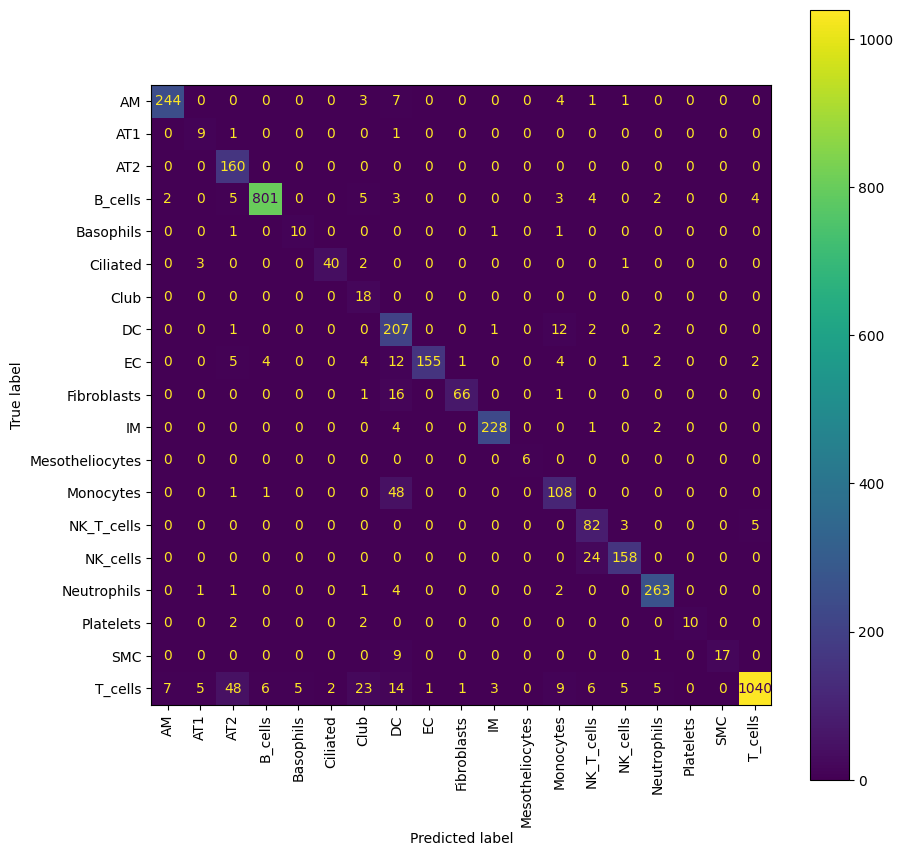

In [7]:
### to run with the previous parameter
y_true = np.array(anndata_raw.obs[key_target])

scrna_unique_clusters = np.unique(anndata_raw.obs[key_target])

scrna_centroids = []

for i in range(len(scrna_unique_clusters)):
    scrna_centroids.append(np.mean(anndata_raw[
                    anndata_raw.obs[key_target] == scrna_unique_clusters[i]].X, axis=0))

y_pred = []
from tqdm import tqdm
for index_cell  in tqdm(range(anndata_raw.shape[0])):
    rna_seq = anndata_raw.X[index_cell]
    norm_expression_vectors = np.array([rna_seq])
    correlation_array = metrics.pairwise.cosine_similarity(norm_expression_vectors,
                                                           np.array(scrna_centroids))[0]
    index_cluster_max = np.argmax(correlation_array)
    pred_rna_seq = scrna_unique_clusters[index_cluster_max]
    y_pred.append(pred_rna_seq)




print(f"Accuracy {metrics.accuracy_score(y_true, y_pred)}")
cm = metrics.confusion_matrix(y_true, y_pred)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_true, y_pred, labels=scrna_unique_clusters)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=scrna_unique_clusters)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax, xticks_rotation = "vertical")

# vizualization of the selected markers

#### Plot the expression level of each gene in each cluster
click on the output figures to zoom

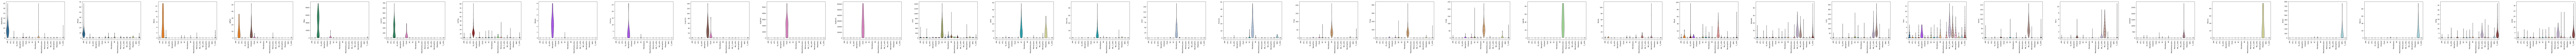

In [9]:
import warnings
warnings.filterwarnings("ignore")
sc.pl.violin(anndata_raw, keys=list_gene, groupby=key_target,
             rotation=90, save='violin_phase.pdf',   use_raw=False)
## click on the output figures to zoom 

## Plot the clustering using the full transcriptome

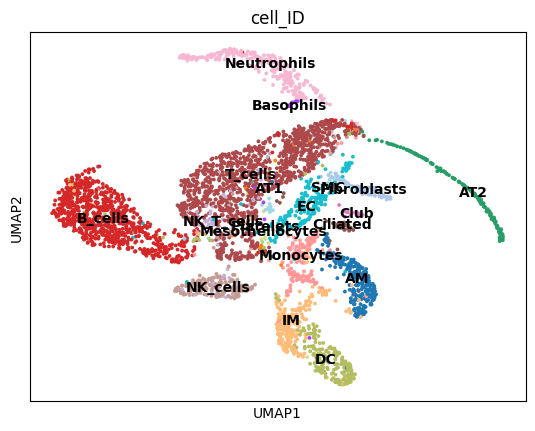

In [13]:
sc.tl.pca(anndata_raw_full, svd_solver='arpack')
sc.pp.neighbors(anndata_raw_full, n_neighbors=20, n_pcs=40)
sc.tl.umap(anndata_raw_full)
sc.pl.umap(anndata_raw_full, color=[key_target], legend_loc='on data')

## Plot the clustering using only the marker genes

The clustering using only the marker genes show similar pattern that the clustering with the full gene list. It means that the choosen marker lists summarize well the full transcriptomic information  

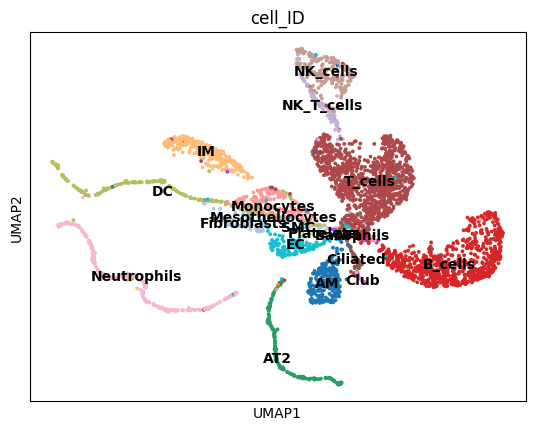

In [14]:
sc.tl.pca(anndata_raw, svd_solver='arpack')
sc.pp.neighbors(anndata_raw, n_neighbors=20, n_pcs=40)
sc.tl.umap(anndata_raw)
sc.pl.umap(anndata_raw, color=[key_target], legend_loc='on data')

## Plot the clustering using with the markers genes vizualizing the expression level of a chosen marker

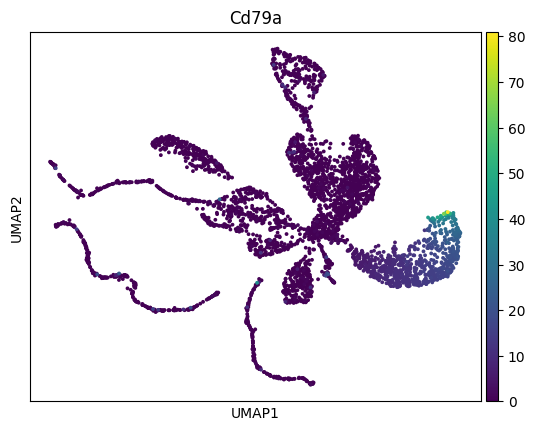

In [20]:
## complete the parker you want to see
marker = 'Cd79a'
####

sc.tl.pca(anndata_raw, svd_solver='arpack')
sc.pp.neighbors(anndata_raw, n_neighbors=20, n_pcs=40)
sc.tl.umap(anndata_raw)
sc.pl.umap(anndata_raw, color=marker, legend_loc='on data', use_raw = False)

## Plot the clustering using with the full transcriptome vizualizing the expression level of a chosen marker

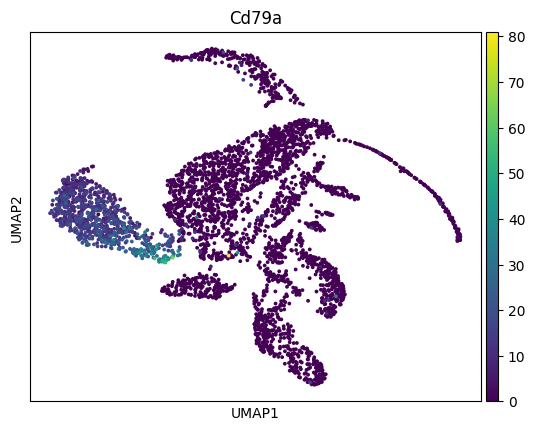

In [19]:
## complete the parker you want to see
marker = 'Cd79a'
####

sc.tl.pca(anndata_raw_full, svd_solver='arpack')
sc.pp.neighbors(anndata_raw_full, n_neighbors=20, n_pcs=40)
sc.tl.umap(anndata_raw_full)
sc.pl.umap(anndata_raw_full, color=marker, legend_loc='on data', use_raw = False)